In [1]:
import os, random, optuna, textstat
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas_profiling import ProfileReport

from scipy.stats import mode
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, GroupKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.naive_bayes import MultinomialNB

import category_encoders as ce

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, Dataset

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\1309427829.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\1309427829.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
ROOT_DIR = "E:\\scrabble-player-rating\\"

In [3]:
train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
turns = pd.read_csv(os.path.join(ROOT_DIR, "turns.csv"))
games = pd.read_csv(os.path.join(ROOT_DIR, "games.csv"))
sub = pd.read_csv(os.path.join(ROOT_DIR, "sample_submission.csv"))

display(train.head())
display(test.head())
display(turns.head())
display(games.head())
display(sub.head())

,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473


,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0


,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play


,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722


,game_id,rating
0,2,1790.322674
1,7,1790.322674
2,11,1790.322674
3,14,1790.322674
4,27,1790.322674


In [4]:
print("train shape:", train.shape)
print("test shape:", test.shape)
print("turns shape:", turns.shape)
print("games shape:", games.shape)
print("submission shape:", sub.shape)

train shape: (100820, 4)
test shape: (44726, 4)
turns shape: (2005498, 9)
games shape: (72773, 12)
submission shape: (22363, 2)


In [5]:
turns.isna().sum()

game_id             0
turn_number         0
nickname            0
rack            69390
location       132239
move              454
points              0
score               0
turn_type         395
dtype: int64

In [6]:
turns[turns['rack'].isna()].head()

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
26,1,27,stevy,NaN,NaN,(O),2,429,End
52,2,26,Super,NaN,NaN,(T),2,488,End
79,3,27,davidavid,NaN,NaN,(IQRRS),28,440,End
139,5,31,stevy,NaN,NaN,(NU),4,325,End
164,6,25,STEEBot,NaN,NaN,(BIU),10,427,End


In [7]:
np.unique(turns[turns['rack'].isna()]['turn_type'], return_counts=True)

(array(['Challenge', 'End', 'Timeout'], dtype=object),
 array([  768, 67987,   635], dtype=int64))

In [8]:
np.unique(turns[turns['rack'].isna()]['move'], return_counts=True)

(array(['(?)', '(??)', '(A)', ..., '(Z?)', '(challenge)', '(time)'],
       dtype=object),
 array([ 113,    4, 1096, ...,    1,  768,  635], dtype=int64))

In [9]:
turns[turns['turn_type'].isna()].head()

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
10249,377,27,NurdiniDelisha,ADFNTTU,O8,NaN,16,249,NaN
11125,409,22,akiff_faleel,AANU,14J,NaN,12,350,NaN
11428,420,23,Rick,AGINU,M12,NaN,19,409,NaN
14720,536,13,HastyBot,AAEILNN,F5,NaN,14,316,NaN
17266,630,2,220674_ZAVEPHUA,AAEINNR,7H,NaN,11,11,NaN


In [10]:
games.isna().sum()

game_id                  0
first                    0
time_control_name        0
game_end_reason          0
winner                   0
created_at               0
lexicon                  0
initial_time_seconds     0
increment_seconds        0
rating_mode              0
max_overtime_minutes     0
game_duration_seconds    0
dtype: int64

In [11]:
test.isna().sum()

game_id         0
nickname        0
score           0
rating      22363
dtype: int64

<AxesSubplot: xlabel='rating', ylabel='Count'>

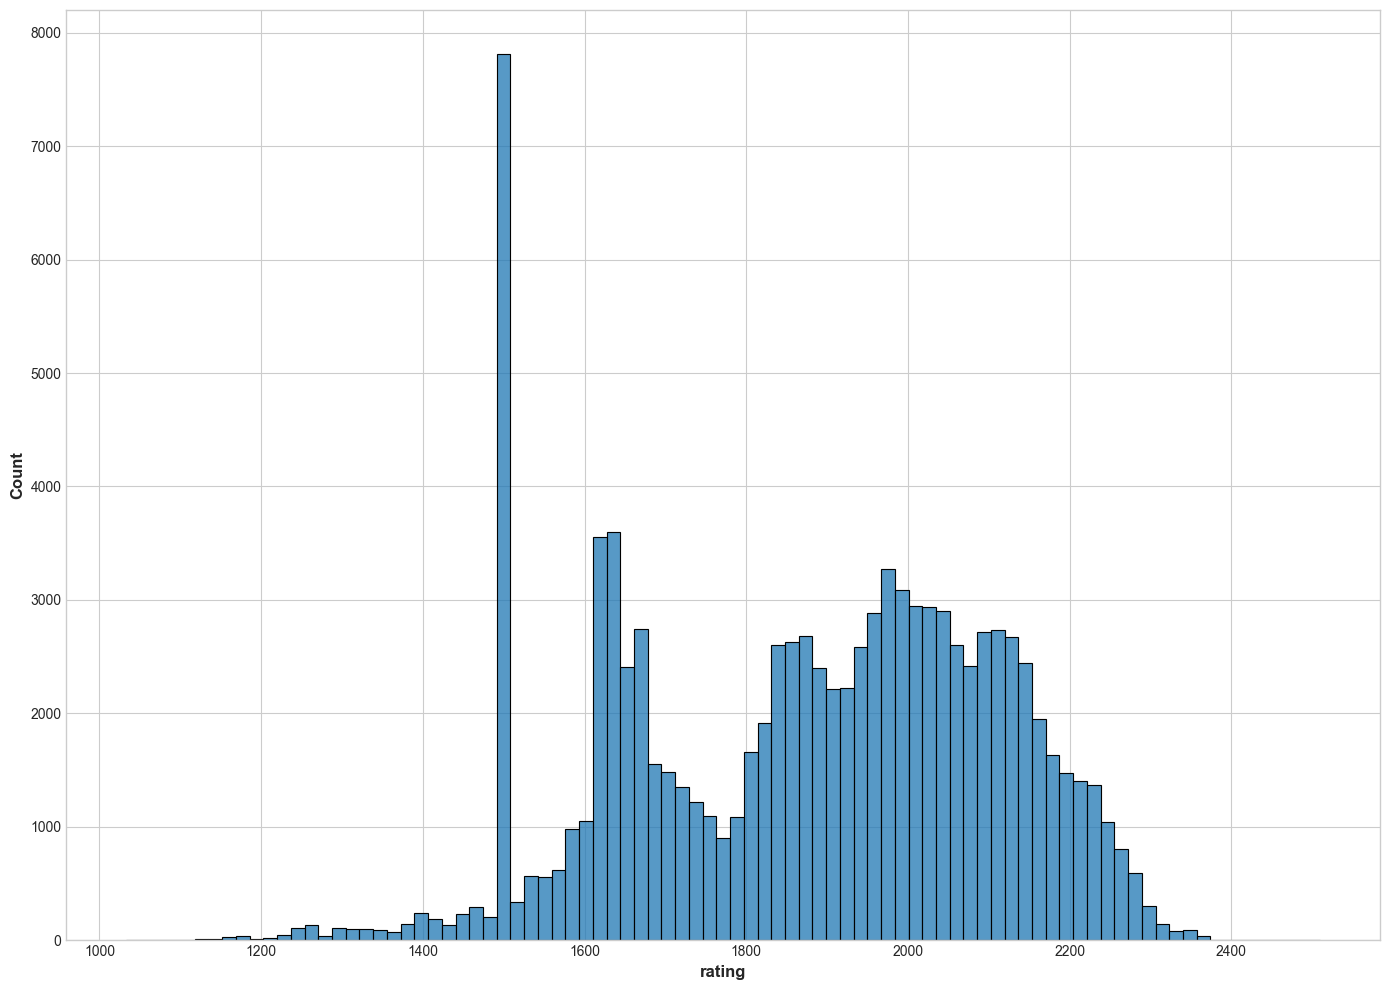

In [12]:
plt.figure(figsize=(14,10))
sns.histplot(train['rating'], ax=plt.gca())

In [13]:
print("primary mode of the target variable: {}".format(mode(train['rating'])))
print("secondary mode of the target variable: {}".format(mode(train[train["rating"]!=1500]['rating'])))

primary mode of the target variable: ModeResult(mode=array([1500], dtype=int64), count=array([7575]))
secondary mode of the target variable: ModeResult(mode=array([1640], dtype=int64), count=array([1857]))


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2768049009.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("primary mode of the target variable: {}".format(mode(train['rating'])))
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2768049009.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True

Text(0.5, 0.98, 'Cummulative distibution of number of games per player')

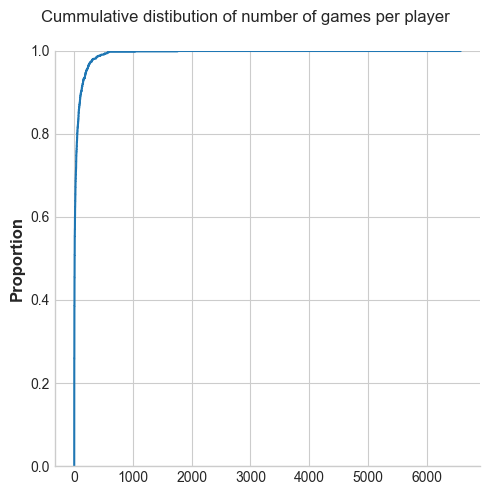

In [14]:
bot_names =["BetterBot", "STEEBot", "HastyBot"]

names, counts= np.unique(train[~train['nickname'].isin(bot_names)]['nickname'], return_counts=True)
plot = sns.displot(counts, kind='ecdf')
plot.fig.suptitle("Cummulative distibution of number of games per player")

In [15]:
print("most games per account: {}".format(np.sort(counts)[-10:]))
print("mean games per account: {}".format(np.mean(counts)))
print("median games per account: {}".format(np.median(counts)))

most games per account: [ 503  511  522  555  561  576  592 1029 1759 6576]
mean games per account: 49.036964980544745
median games per account: 8.0


In [16]:
bot_df = train[["game_id", "nickname", "score", "rating"]].copy()
bot_df['bot_name'] = bot_df['nickname'].apply(lambda x: x if x in bot_names else np.nan)
bot_df = bot_df[["game_id", "score", "rating", "bot_name"]].dropna(subset=["bot_name"])
bot_df.columns = ["game_id", "bot_score", "bot_rating", "bot_name"]

In [17]:
full_df = train[~train['nickname'].isin(bot_names)] 
full_df = full_df.merge(bot_df, on="game_id")
full_df = full_df.merge(games, on="game_id")
full_df["created_at"] = pd.to_datetime(full_df["created_at"]) 

In [18]:
full_df[full_df['bot_name'].isna()]

,game_id,nickname,score,rating,bot_score,bot_rating,bot_name,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds


In [19]:
nickname = full_df["nickname"].sample(1).values[0]
print(nickname)

full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]]

rak1507


,created_at,rating,bot_name
11446,2022-07-28 00:42:02,1932,STEEBot
5975,2022-07-28 00:47:11,1946,STEEBot
21098,2022-07-28 00:56:05,1940,STEEBot
4793,2022-07-28 01:01:15,1934,STEEBot
47055,2022-07-30 02:09:15,1929,STEEBot
...,...,...,...
28286,2022-09-21 19:00:50,2043,HastyBot
38883,2022-09-21 19:04:48,2039,HastyBot
854,2022-09-21 19:10:00,2034,HastyBot
24282,2022-09-21 19:14:30,2030,HastyBot


Text(0.5, 1.0, 'Player rak1507 scores over the course of thier games, by bot')

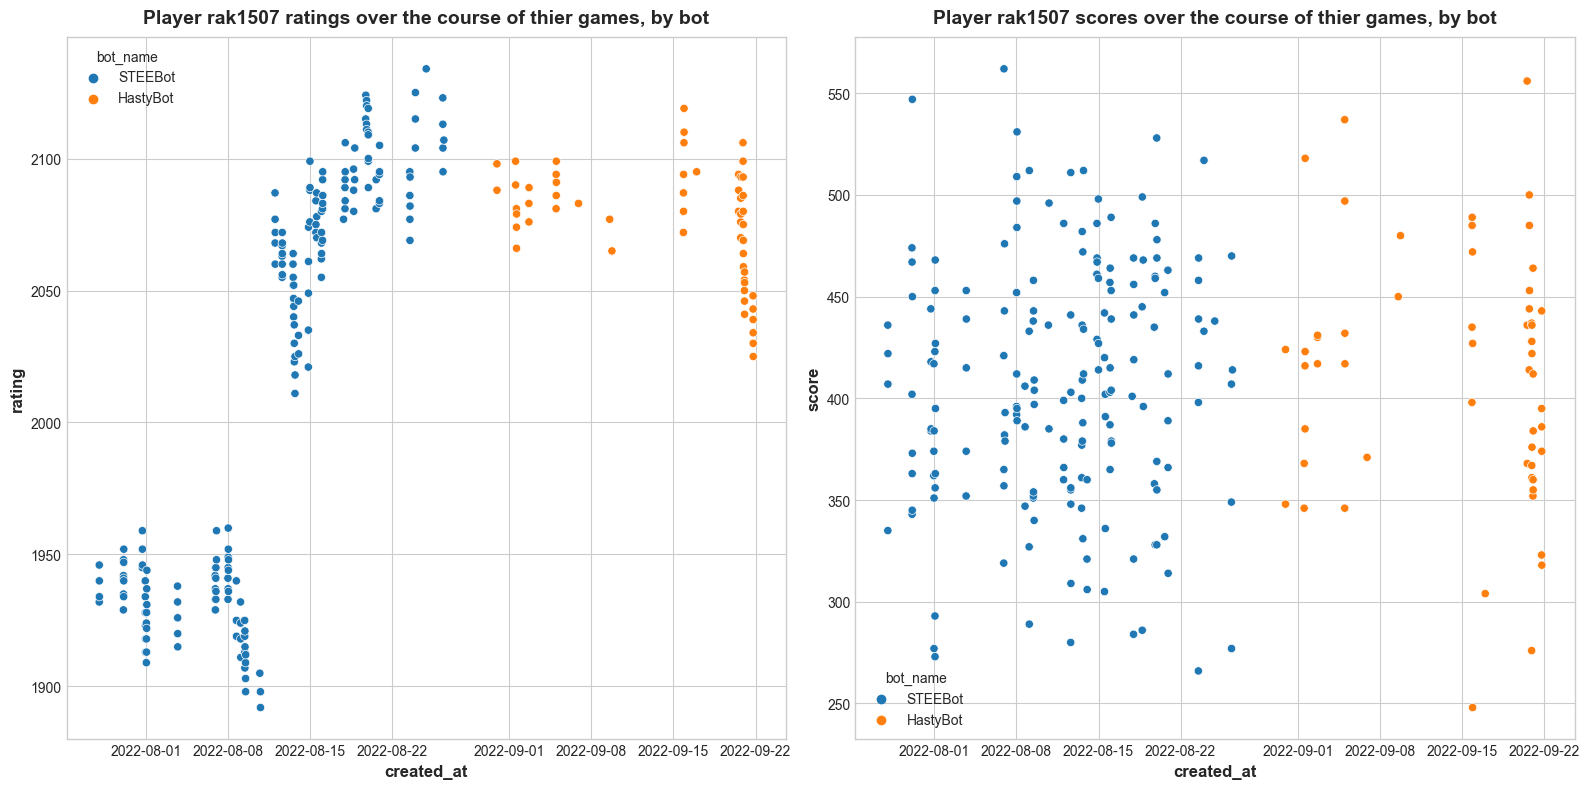

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]], x="created_at", y="rating", hue="bot_name", ax=axes[0])
axes[0].set_title("Player {} ratings over the course of thier games, by bot".format(nickname))

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "score", "bot_name"]], x="created_at", y="score", hue="bot_name", ax=axes[1])
axes[1].set_title("Player {} scores over the course of thier games, by bot".format(nickname))

In [21]:
users, counts = np.unique(full_df[full_df['rating'] == 1500]['nickname'], return_counts=True)

print("number of users with 1500 rating: {}".format(len(users)))
print("counts per user")
print(counts)

number of users with 1500 rating: 108
counts per user
[   7    1    1    1    2 6576   17    3    2    1    1    1    2    1
    1   99   16    1    1    1    1    1    1   13    1    1    1    3
    1    1    1    1    3    1    1    1    1    1    1   81    2    1
    2    1    1    6    3    1    1    1    1   14    1    1    3    1
    1    2    1   89    9    2    1    1    1    1    1    1    1    1
    1    1    1    1    1    1   51    1    1    1    1    1    1    1
    1    1    1    3   35    1    1    1    1   27    1    1    1    3
    3    1    1  410    2    2    7    2    1    1]


In [22]:
print("users with a high number of 1500 ratings: ")
print(users[np.argsort(counts)[::-1][:34]])
print("...and their counts of 1500 scores: ")
print(counts[np.argsort(counts)[::-1][:34]])

users with a high number of 1500 ratings: 
['BB-8' 'stevy' 'CobaltBlue' 'TT9000' 'MankDemes' 'evatt' 'matterhorn'
 'naushika' 'Best459' 'CodeTitan' 'SGP' 'HaDZ' 'TheOneWhoKnocks' 'Alexaa'
 'thyme' 'Piro' 'marcmyword' 'replacehim' 'Scal' 'J-Oriola' 'Kidikibudi'
 'puddingy1' 'Pranjal1307' 'BethMix' 'Mollygardner' 'Nickphone'
 'SmartGoose' 'thompson8295' 'suffixt' 'Toronto2' 'tripack' 'Arnav1'
 'Bingobabe' 'Casty']
...and their counts of 1500 scores: 
[6576  410   99   89   81   51   35   27   17   16   14   13    9    7
    7    6    3    3    3    3    3    3    3    3    2    2    2    2
    2    2    2    2    2    2]


In [23]:
nickname = 'BB-8'
full_df[full_df["nickname"]=='BB-8'].sort_values(by="created_at")[["created_at", "rating", "bot_name"]]

,created_at,rating,bot_name
30512,2022-08-26 06:00:26,1500,HastyBot
12112,2022-08-26 06:05:42,1500,HastyBot
47174,2022-08-26 06:10:01,1500,HastyBot
31584,2022-08-26 06:14:56,1500,HastyBot
13209,2022-08-26 06:20:02,1500,HastyBot
...,...,...,...
394,2022-09-23 15:15:49,1500,HastyBot
17170,2022-09-23 15:20:13,1500,HastyBot
5924,2022-09-23 15:24:34,1500,HastyBot
27351,2022-09-23 15:30:16,1500,HastyBot


Text(0.5, 1.0, 'Player BB-8 scores over the course of their games, by bot')

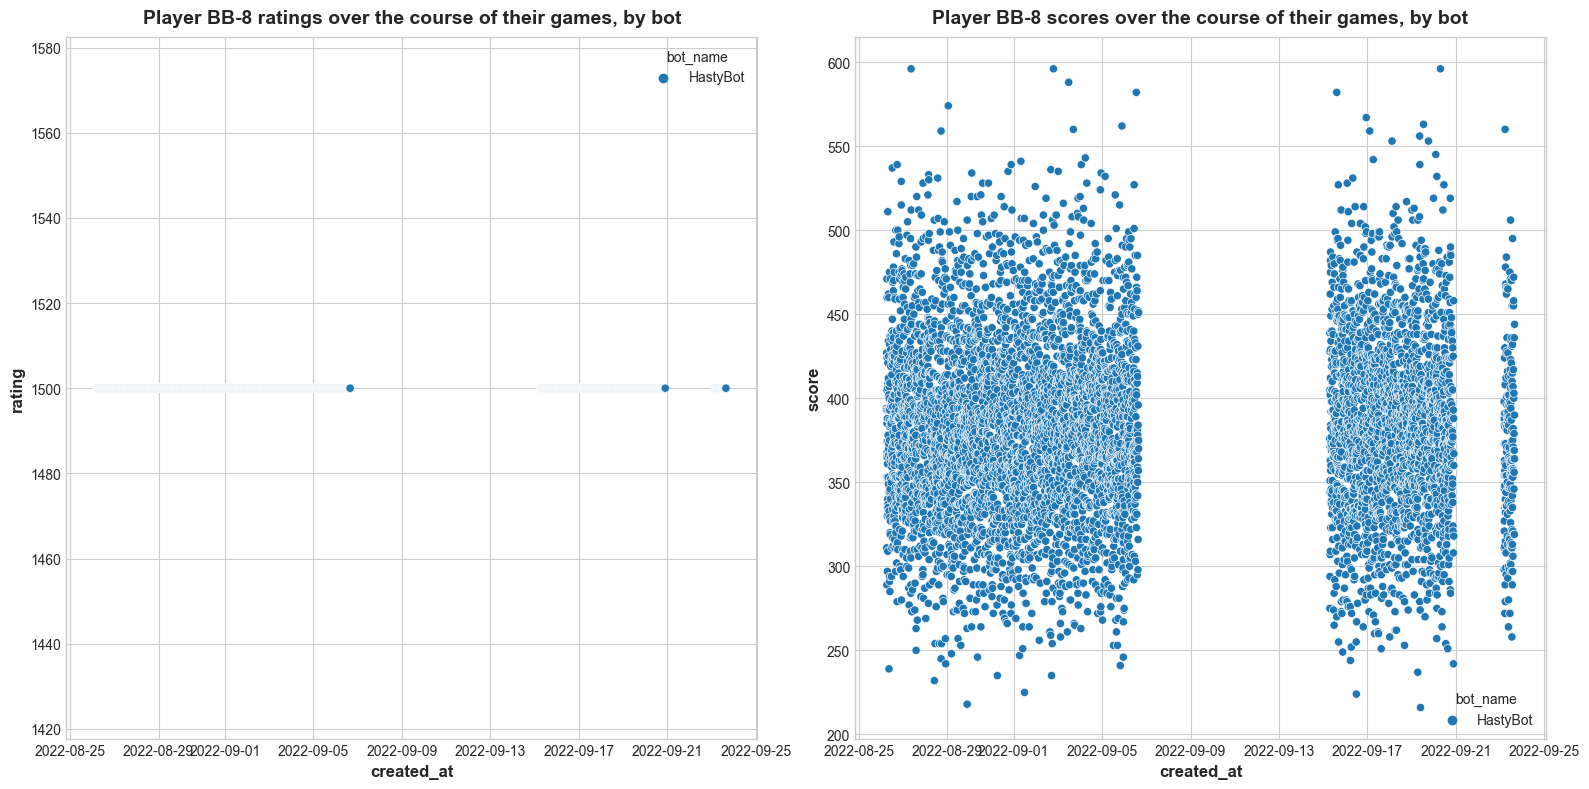

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]], x="created_at", y="rating", hue="bot_name", ax=axes[0])
axes[0].set_title("Player {} ratings over the course of their games, by bot".format(nickname))

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "score", "bot_name"]], x="created_at", y="score", hue="bot_name", ax=axes[1])
axes[1].set_title("Player {} scores over the course of their games, by bot".format(nickname))

In [25]:
nickname = 'stevy'
full_df[full_df["nickname"]=='BB-8'].sort_values(by="created_at")[["created_at", "rating", "bot_name"]]

,created_at,rating,bot_name
30512,2022-08-26 06:00:26,1500,HastyBot
12112,2022-08-26 06:05:42,1500,HastyBot
47174,2022-08-26 06:10:01,1500,HastyBot
31584,2022-08-26 06:14:56,1500,HastyBot
13209,2022-08-26 06:20:02,1500,HastyBot
...,...,...,...
394,2022-09-23 15:15:49,1500,HastyBot
17170,2022-09-23 15:20:13,1500,HastyBot
5924,2022-09-23 15:24:34,1500,HastyBot
27351,2022-09-23 15:30:16,1500,HastyBot


Text(0.5, 1.0, 'Player stevy scores over the course of their games, by bot')

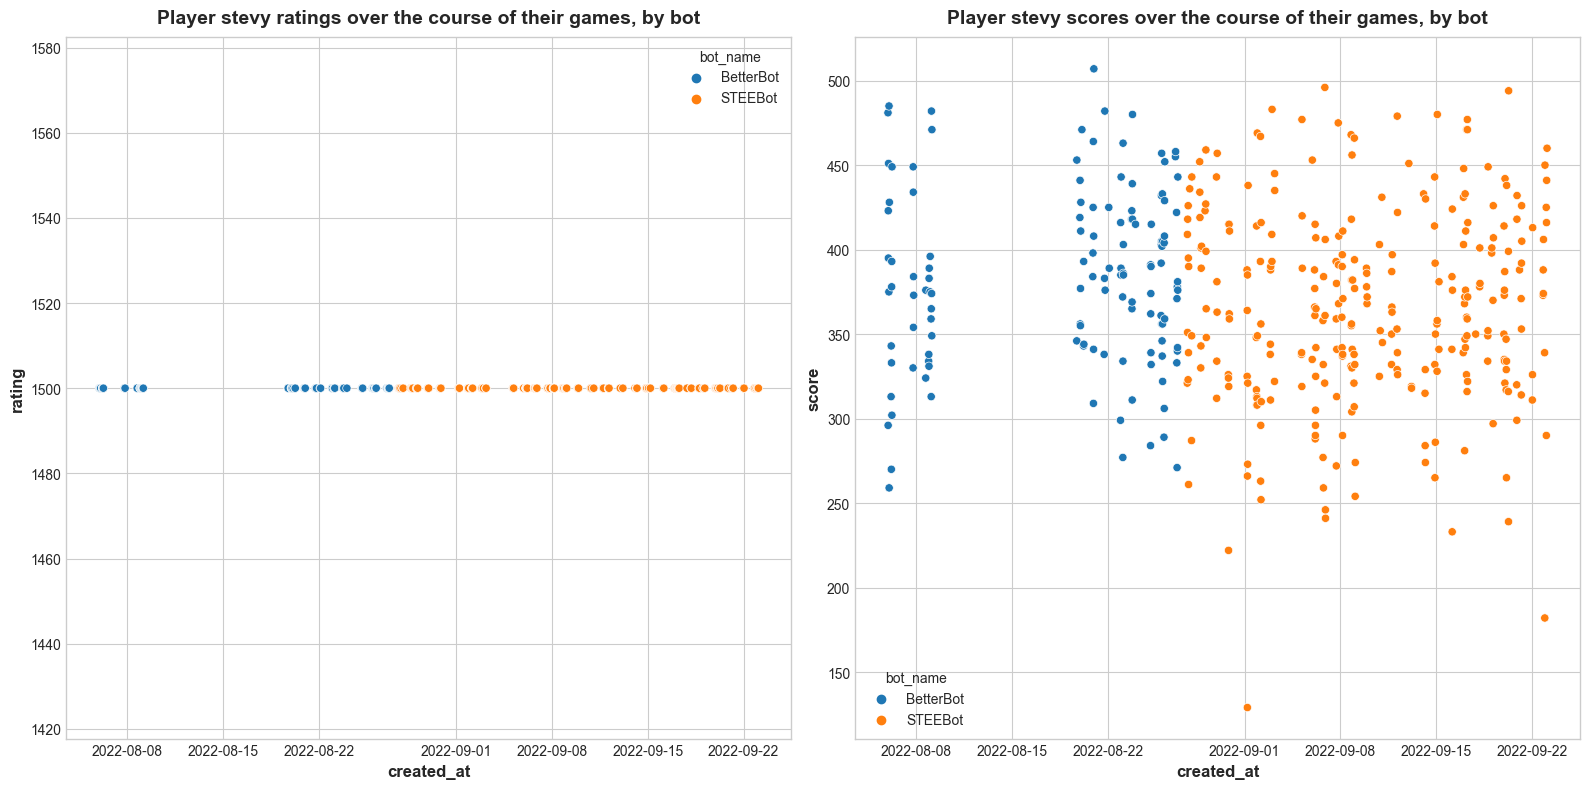

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]], x="created_at", y="rating", hue="bot_name", ax=axes[0])
axes[0].set_title("Player {} ratings over the course of their games, by bot".format(nickname))

sns.scatterplot(data = full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "score", "bot_name"]], x="created_at", y="score", hue="bot_name", ax=axes[1])
axes[1].set_title("Player {} scores over the course of their games, by bot".format(nickname))

In [27]:
nickname = 'BethMix'
full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]]

,created_at,rating,bot_name
26876,2022-08-07 01:32:07,1491,BetterBot
23203,2022-08-09 03:32:40,1608,STEEBot
613,2022-08-09 18:50:03,1604,STEEBot
49980,2022-08-09 18:59:12,1618,STEEBot
16880,2022-08-10 20:33:42,1608,STEEBot
...,...,...,...
27695,2022-09-22 20:30:18,1569,HastyBot
12885,2022-09-22 23:46:57,1567,HastyBot
15023,2022-09-22 23:51:53,1565,HastyBot
15632,2022-09-23 00:46:05,1563,HastyBot


Text(0.5, 1.0, 'Player BethMix scores over the course of thier games, by bot')

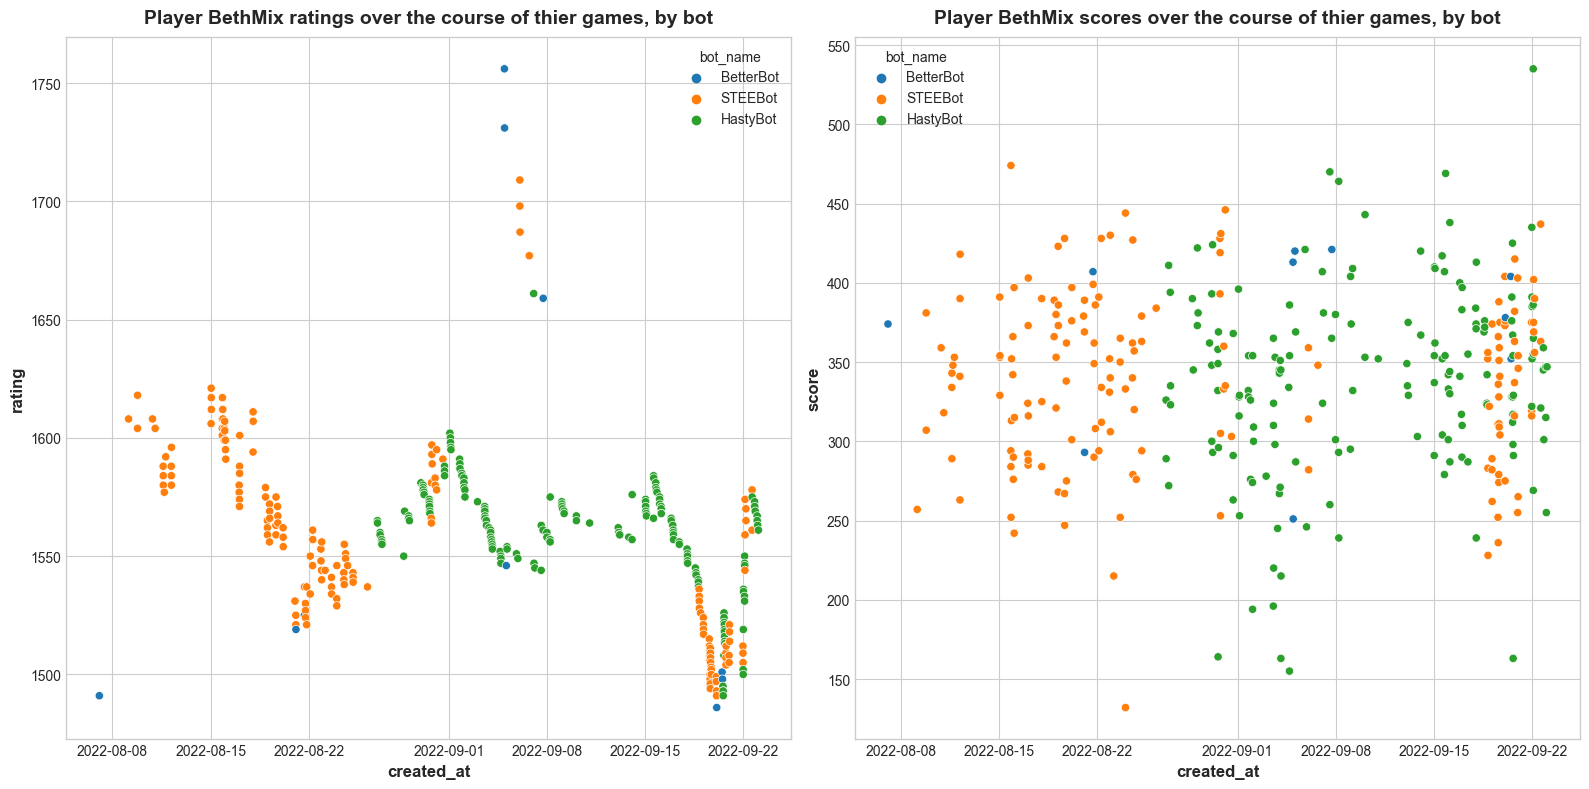

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))

sns.scatterplot(data=full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "rating", "bot_name"]], x="created_at", y="rating", hue="bot_name", ax=axes[0])
axes[0].set_title("Player {} ratings over the course of thier games, by bot".format(nickname))

sns.scatterplot(data=full_df[full_df["nickname"]==nickname].sort_values(by="created_at")[["created_at", "score", "bot_name"]], x="created_at", y="score", hue="bot_name", ax=axes[1])
axes[1].set_title("Player {} scores over the course of thier games, by bot".format(nickname))

In [29]:
df = full_df[full_df['nickname'].isin(users)][['nickname', 'rating']].groupby('nickname').agg({"nickname":"count",
                                                                                         "rating" : lambda x: np.sum(x == 1500)
                                                                                         })
df["ratio"] = df["rating"]/df["nickname"]
print("number of accounts that only have 1500 ratings and more than one game: {}".format(len(df[(df["ratio"] >=1.0) & (df["nickname"]>1)])))

number of accounts that only have 1500 ratings and more than one game: 20


In [30]:
df[(df["ratio"] >=1.0) & (df["nickname"]>1)]

,nickname,rating,ratio
nickname,,,
Alexaa,7,7,1.0
BB-8,6576,6576,1.0
CobaltBlue,99,99,1.0
CodeTitan,16,16,1.0
HaDZ,13,13,1.0
Kidikibudi,3,3,1.0
MankDemes,81,81,1.0
Nickphone,2,2,1.0
SGP,14,14,1.0


Text(0.5, 1.0, 'Ratings for Players with Only One Game')

<Figure size 1600x800 with 0 Axes>

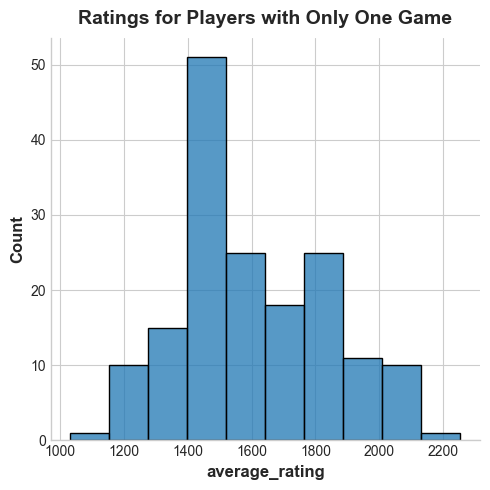

In [31]:
game_count_and_rating_df = full_df.groupby("nickname").agg({"nickname":"count", "rating":"mean"})
game_count_and_rating_df.columns = ["counts_of_games", "average_rating"]

plt.figure(figsize=(16,8))
sns.displot(game_count_and_rating_df[game_count_and_rating_df["counts_of_games"] ==1]["average_rating"])
plt.title("Ratings for Players with Only One Game")

In [32]:
game_count_and_rating_df.corr()

,counts_of_games,average_rating
counts_of_games,1.000000,0.059838
average_rating,0.059838,1.000000


In [33]:
casual_df = full_df.copy()
casual_df["rating_mode"] = casual_df["rating_mode"].apply(lambda x: 1 if x=="CASUAL" else 0)

user_casual_game_frac_df = casual_df.groupby("nickname").agg({"rating_mode":"mean"})
casual_only_users = user_casual_game_frac_df[user_casual_game_frac_df["rating_mode"] >= 1.0].index

In [34]:
np.unique(casual_df[casual_df["nickname"].isin(casual_only_users)].groupby("nickname").agg({"rating":"std"}).sort_values("rating", ascending=False) >0,
          return_counts=True)

(array([False,  True]), array([140,  61], dtype=int64))

In [35]:
full_df[full_df["nickname"] == "J-Oriola"].sort_values("created_at")

,game_id,nickname,score,rating,bot_score,bot_rating,bot_name,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
34097,49224,J-Oriola,293,1860,368,1983,BetterBot,BetterBot,regular,STANDARD,0,2022-08-09 14:52:20,CSW21,1200,0,CASUAL,5,1494.058375
49995,72163,J-Oriola,335,1860,428,1965,BetterBot,J-Oriola,regular,STANDARD,0,2022-08-09 15:17:33,CSW21,1200,0,CASUAL,5,1242.691088
50371,72703,J-Oriola,217,1500,362,1934,BetterBot,BetterBot,rapid,TIME,0,2022-08-09 19:50:27,CSW21,600,0,CASUAL,1,665.512711
28831,41620,J-Oriola,248,1500,434,1934,BetterBot,J-Oriola,rapid,STANDARD,0,2022-08-09 20:01:47,CSW21,600,0,CASUAL,1,627.317148
31152,44936,J-Oriola,241,1500,336,1934,BetterBot,J-Oriola,rapid,TIME,0,2022-08-09 20:13:59,CSW21,600,0,CASUAL,1,665.441268
3078,4452,J-Oriola,77,1448,381,2202,HastyBot,HastyBot,rapid,TIME,0,2022-09-17 21:17:25,CSW21,600,0,CASUAL,1,671.711263


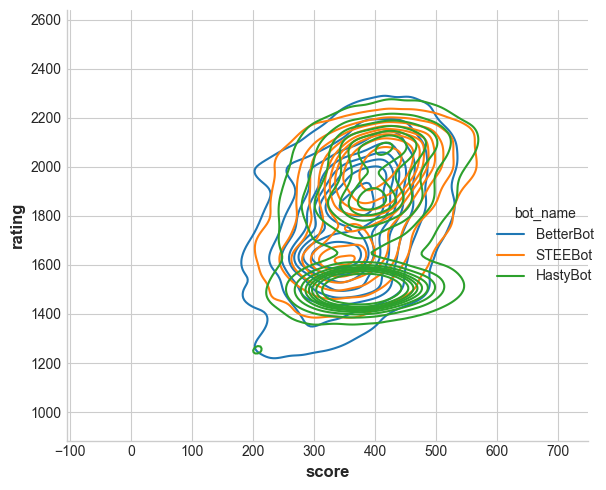

In [36]:
sns.displot(full_df[["rating", "score", "bot_name"]], x="score", y="rating", hue="bot_name", kind="kde")

D:\Python3.11.3\Lib\site-packages\seaborn\distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


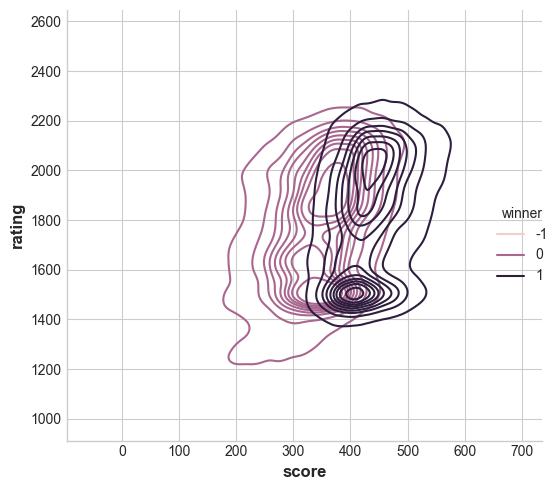

In [37]:
sns.displot(full_df[["rating", "score", "winner"]], x="score", y="rating", hue="winner", kind="kde")

In [38]:


player_avg_performance = full_df[["nickname","score","rating", "winner", "game_duration_seconds"]].groupby("nickname").agg({"score":"mean", 
                                                                                                                            "rating":"mean", 
                                                                                                                            "winner":"sum", 
                                                                                                                            "nickname":"count",
                                                                                                                            "game_duration_seconds":"mean",
                                                                                                                            
                                                                                                                           })
player_avg_performance["win_ratio"] = player_avg_performance["winner"] / player_avg_performance["nickname"]

Text(0.5, 0.98, 'Distribution of scores by ratings, averaged over each player')

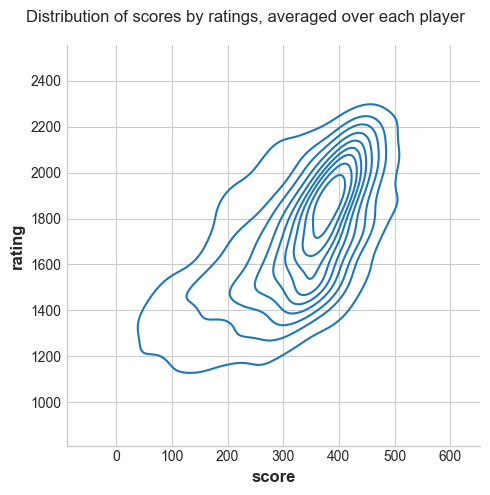

In [39]:
plot = sns.displot(player_avg_performance, x="score", y="rating", kind="kde")
plot.fig.suptitle("Distribution of scores by ratings, averaged over each player")

Text(0.5, 0.98, 'Distribution of the win ratio by ratings, averaged over each player')

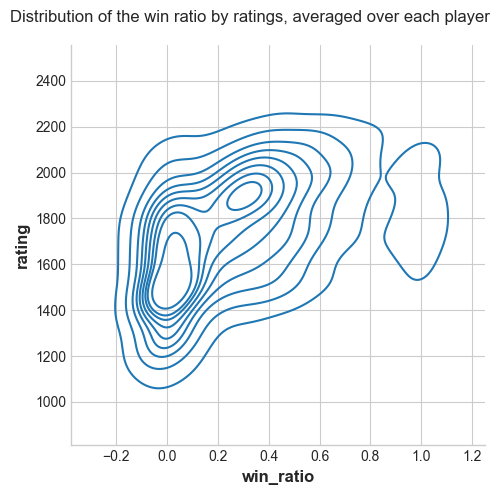

In [40]:
plot = sns.displot(player_avg_performance, x="win_ratio", y="rating", kind="kde")
plot.fig.suptitle("Distribution of the win ratio by ratings, averaged over each player")

Text(0.5, 0.98, 'Distribution of game duration by ratings, averaged over each player')

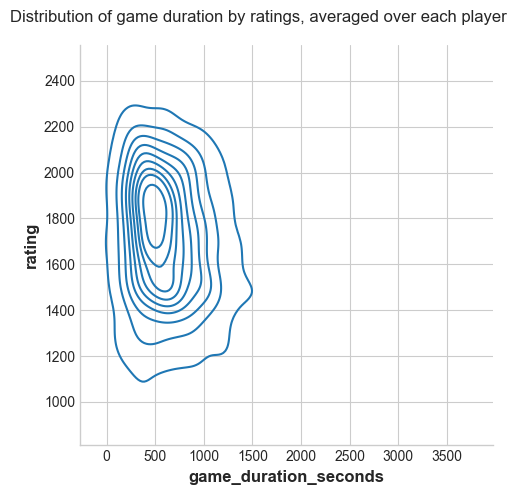

In [41]:
plot = sns.displot(player_avg_performance, x="game_duration_seconds", y="rating", kind="kde")
plot.fig.suptitle("Distribution of game duration by ratings, averaged over each player")

In [42]:
print("Correlation between a players average score and their average rating {:.3f}".format(player_avg_performance["score"].corr(player_avg_performance["rating"])))
print("Correlation between a players number of wins and their average rating {:.3f}".format(player_avg_performance["score"].corr(player_avg_performance["winner"])))
print("Correlation between a players average win ratio and their average rating {:.3f}".format(player_avg_performance["score"].corr(player_avg_performance["win_ratio"])))
print("Correlation between a players average game duration and their average rating {:.3f}".format(player_avg_performance["score"].corr(player_avg_performance["game_duration_seconds"])))

Correlation between a players average score and their average rating 0.611
Correlation between a players number of wins and their average rating 0.102
Correlation between a players average win ratio and their average rating 0.641
Correlation between a players average game duration and their average rating 0.022


In [43]:
def fe_turns(df):

    df["rack_len"] = df["rack"].str.len()
    df["rack_len_less_than_7"] = df["rack_len"].apply(lambda x : x <7)
    df["move_len"] = df["move"].str.len()
    df["move"].fillna("None",inplace=True)
    df["difficult_word"] = df["move"].apply(textstat.difficult_words)
    rare_letters = ["Z", "Q", "J", "X", "K", "V", "Y", "W", "G"]
    df["difficult_letters"] = df["move"].apply(lambda x: len([letter for letter in x if letter in rare_letters]))
    df["points_per_letter"] = df["points"]/df["move_len"]
    
    df["turn_type"].fillna("None",inplace=True)
    turn_type_unique = df["turn_type"].unique()
    df = pd.get_dummies(df, columns=["turn_type"])
    dummy_features = [f"turn_type_{value}" for value in turn_type_unique]
    
    char_map = {
        'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8,
        'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
    }
    df['y'] = df["location"].str.extract('(\d+)')[0].values
    df['y'].fillna("0",inplace=True)
    df["y"] = df["y"].astype(int)
    
    df["x"] = df["location"].str.extract('([A-Z])')[0].values
    df["x"].replace(char_map, inplace=True)
    df['x'].fillna("0",inplace=True)
    df["x"] = df["x"].astype(int)
    
    df["direction_of_play"] = df["location"].apply(lambda x: 1 if str(x)[0].isdigit() else 0)
    
    df["curr_board_pieces_used"] = df["move"].apply(lambda x: str(x).count(".") + sum(int(c.islower()) for c in str(x)))
    
    return df, dummy_features

In [44]:
turns_fe, dummy_features = fe_turns(turns.copy())
agg_func_counts = {feature:'sum' for feature in dummy_features}
turns_grouped_counts = turns_fe.groupby(["game_id", "nickname"], as_index=False).agg(agg_func_counts)

agg_func_stats = {
    "points":["mean", "max"],
    "move_len":["mean", "max"],
    "difficult_word":["mean", "sum"],
    "difficult_letters":["mean", "sum"],
    "points_per_letter":"mean",
    "curr_board_pieces_used": "mean",
    "direction_of_play": "mean",
    "rack_len_less_than_7" : "sum",
    "turn_number" : "count"
}
turns_grouped_stats = turns_fe[turns_fe["turn_type_Play"]==1].groupby(["game_id", "nickname"], as_index=False).agg(agg_func_stats)
turns_grouped_stats.columns = ["_".join(a) if a[0] not in ["game_id", "nickname"] else a[0] for a in turns_grouped_stats.columns.to_flat_index()]
turns_grouped = turns_grouped_counts.merge(turns_grouped_stats, how="outer", on =["game_id", "nickname"])
turns_grouped.fillna(value=0, inplace=True)

In [45]:
full_df = full_df.merge(turns_grouped, how="left", on=["game_id", "nickname"])

<AxesSubplot: >

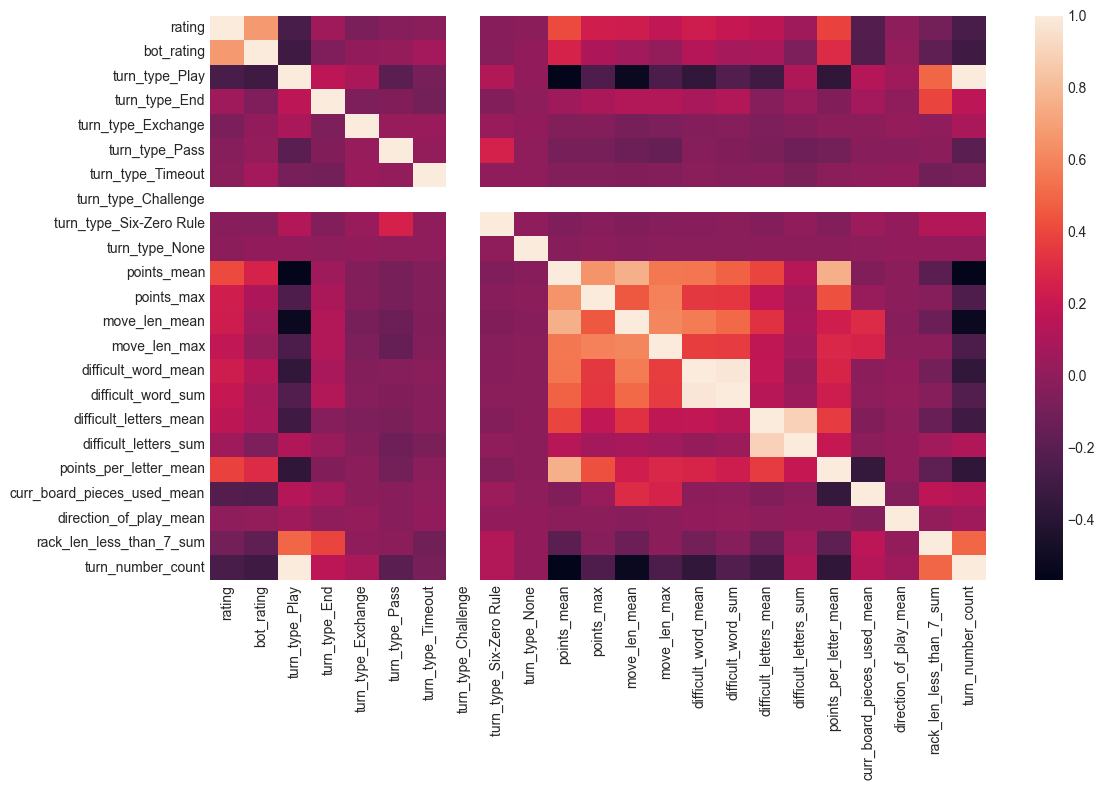

In [46]:
plt.figure(figsize=(12,8))
sns.heatmap(full_df[['rating', 'bot_rating'] +list(turns_grouped.columns[2:])].corr())

In [47]:
def create_turn_features(df):

    df["rack_len"] = df["rack"].str.len()
    df["rack_len_less_than_7"] = df["rack_len"].apply(lambda x : x <7)
    df["move_len"] = df["move"].str.len()
    df["move"].fillna("None",inplace=True)
    df["difficult_word"] = df["move"].apply(textstat.difficult_words)
    rare_letters = ["Z", "Q", "J", "X", "K", "V", "Y", "W", "G"]
    df["difficult_letters"] = df["move"].apply(lambda x: len([letter for letter in x if letter in rare_letters]))
    df["points_per_letter"] = df["points"]/df["move_len"]
    
    df["turn_type"].fillna("None",inplace=True)
    turn_type_unique = df["turn_type"].unique()
    df = pd.get_dummies(df, columns=["turn_type"])
    dummy_features = [f"turn_type_{value}" for value in turn_type_unique]
    
    char_map = {
        'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8,
        'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
    }
    df['y'] = df["location"].str.extract('(\d+)')[0].values
    df['y'].fillna("0",inplace=True)
    df["y"] = df["y"].astype(int)
    
    df["x"] = df["location"].str.extract('([A-Z])')[0].values
    df["x"].replace(char_map, inplace=True)
    df['x'].fillna("0",inplace=True)
    df["x"] = df["x"].astype(int)
    
    df["direction_of_play"] = df["location"].apply(lambda x: 1 if str(x)[0].isdigit() else 0)
    
    df["curr_board_pieces_used"] = df["move"].apply(lambda x: str(x).count(".") + sum(int(c.islower()) for c in str(x)))
    
    agg_func_counts = {feature:'sum' for feature in dummy_features}
    turns_grouped_counts = df.groupby(["game_id", "nickname"], as_index=False).agg(agg_func_counts)

    agg_func_stats = {
        "points":["mean", "max"],
        "move_len":["mean", "max"],
        "difficult_word":["mean", "sum"],
        "difficult_letters":["mean", "sum"],
        "points_per_letter":"mean",
        "curr_board_pieces_used": "mean",
        "direction_of_play": "mean",
        "rack_len_less_than_7" : "sum",
        "turn_number" : "count"
    }
    

    turns_grouped_stats = df[df["turn_type_Play"]==1].groupby(["game_id", "nickname"], as_index=False).agg(agg_func_stats)
    turns_grouped_stats.columns = ["_".join(a) if a[0] not in ["game_id", "nickname"] else a[0] for a in turns_grouped_stats.columns.to_flat_index()]
    turns_grouped = turns_grouped_counts.merge(turns_grouped_stats, how="outer", on =["game_id", "nickname"])
    turns_grouped.fillna(value=0, inplace=True)
    
    return turns_grouped

In [48]:
def load_data(bot_names =["BetterBot", "STEEBot", "HastyBot"], cat_features=[]):
    train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
    test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
    turns = pd.read_csv(os.path.join(ROOT_DIR, "turns.csv"))
    games = pd.read_csv(os.path.join(ROOT_DIR, "games.csv"))
    
    df = pd.concat([train, test])
    

    turns_fe_df = create_turn_features(turns)
    df = df.merge(turns_fe_df, how="left", on=["game_id", "nickname"])
    

    bot_turns_columns = [i for i in turns_fe_df.columns.tolist() if i not in ["game_id", "nickname"]]
    bot_df = df[["game_id", "nickname", "score", "rating"]+bot_turns_columns].copy()
    bot_df['bot_name'] = bot_df['nickname'].apply(lambda x: x if x in bot_names else np.nan)
    bot_df = bot_df[["game_id", "bot_name", "score", "rating"]+bot_turns_columns].dropna(subset=["bot_name"])
    bot_df.columns = ["game_id", "bot_name", "bot_score", "bot_rating"]+["bot_"+i for i in bot_turns_columns]
    

    df = df[~df['nickname'].isin(bot_names)] #take out the bots
    df = df.merge(bot_df, on="game_id") #add in bot information
    df = df.merge(games, on="game_id") # add in game information
    df["created_at"] = pd.to_datetime(df["created_at"]) #convert to datetime
    df["first"] = df["first"].apply(lambda x: 'bot' if x in bot_names else "player")

    for name in cat_features:
        df[name] = df[name].astype("category")
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)

    train = df[df["game_id"].isin(train["game_id"])].set_index("game_id")
    test = df[df["game_id"].isin(test["game_id"])].set_index("game_id")
    return train, test

In [49]:
train, test = load_data(cat_features = ["nickname","bot_name", "time_control_name", "first", "game_end_reason", "winner", "lexicon", "rating_mode"])

C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2107607743.py:30: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[name].cat.add_categories("None", inplace=True)
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2107607743.py:30: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[name].cat.add_categories("None", inplace=True)
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2107607743.py:30: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df[name].cat.add_categories("None", inplace=True)
C:\Users\MNA\AppData\Local\Temp\ipykerne

In [50]:
def score_dataset(X, y, 
                  model=LGBMRegressor(n_estimators=1000, verbose=-1, random_state=42)
                 ):
    
    X = X.copy()
    groups = X.pop('nickname')
    
    scores = cross_validate(
        model, X, y, cv=GroupKFold(), groups=groups, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True
    )
    
    return {"Training":-1*np.mean(scores["train_score"]), "Validation":-1*np.mean(scores["test_score"])}

In [51]:
base_features = ['nickname', 'score', 'turn_type_Play', 'turn_type_End', 'turn_type_Exchange', 'turn_type_Pass', 'turn_type_Timeout',
                 'turn_type_Challenge', 'turn_type_Six-Zero Rule', 'turn_type_None','points_mean', 'points_max', 'move_len_mean', 'move_len_max',
                 'difficult_word_mean', 'difficult_word_sum', 'difficult_letters_mean', 'difficult_letters_sum', 'points_per_letter_mean',
                 'curr_board_pieces_used_mean', 'direction_of_play_mean', 'rack_len_less_than_7_sum', 'turn_number_count', 'bot_name',
                 'bot_score', 'bot_rating', 'bot_turn_type_Play', 'bot_turn_type_End', 'bot_turn_type_Exchange', 'bot_turn_type_Pass', 'bot_turn_type_Timeout',
                 'bot_turn_type_Challenge', 'bot_turn_type_Six-Zero Rule', 'bot_turn_type_None', 'bot_points_mean', 'bot_points_max',
                 'bot_move_len_mean', 'bot_move_len_max', 'bot_difficult_word_mean', 'bot_difficult_word_sum', 'bot_difficult_letters_mean',
                 'bot_difficult_letters_sum', 'bot_points_per_letter_mean', 'bot_curr_board_pieces_used_mean', 'bot_direction_of_play_mean',
                 'bot_rack_len_less_than_7_sum', 'bot_turn_number_count', 'first', 'time_control_name', 'game_end_reason', 'winner',
                 'lexicon', 'initial_time_seconds', 'increment_seconds', 'rating_mode', 'max_overtime_minutes', 'game_duration_seconds']

In [52]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
y = train["rating"]

In [53]:
score_dataset(X, y)

{'Training': 60.6772211815631, 'Validation': 163.36449248899106}

In [54]:
def create_cumm_player_features_overall(df):

    df = df[["nickname", "created_at","score","winner", "game_duration_seconds"]]
    
   
    df= df.sort_values(by="created_at")

    df["cumm_avg_player_score"] = np.zeros(len(df))
    df["cumm_max_player_score"] = np.zeros(len(df))
    df["cumm_min_player_score"] = np.zeros(len(df))
    df["cumm_total_player_score"] = np.zeros(len(df))
    df["cumm_player_wins"] = np.zeros(len(df))
    df["cumm_avg_player_win_ratio"] = np.zeros(len(df))
    df["cumm_avg_game_duration_seconds"] = np.zeros(len(df))

    for nickname in df["nickname"].unique():

        df.loc[df["nickname"]==nickname, "cumm_avg_player_score"]= np.append(0, df[df["nickname"]==nickname]["score"].expanding(min_periods=1).mean().values[:-1])
        df.loc[df["nickname"]==nickname, "cumm_max_player_score"]= np.append(0, df[df["nickname"]==nickname]["score"].expanding(min_periods=1).max().values[:-1])
        df.loc[df["nickname"]==nickname, "cumm_min_player_score"]= np.append(0, df[df["nickname"]==nickname]["score"].expanding(min_periods=1).min().values[:-1])
        
        df.loc[df["nickname"]==nickname, "cumm_player_wins"]= np.append(0, df[df["nickname"]==nickname]["winner"].expanding(min_periods=1).sum().values[:-1])
        
        df.loc[df["nickname"]==nickname, "cumm_avg_player_win_ratio"]= \
        df[df["nickname"]==nickname]["cumm_player_wins"] / np.append(0, df[df["nickname"]==nickname]["winner"].expanding(min_periods=1).count().values[:-1])
        
        df.loc[df["nickname"]==nickname, "cumm_avg_game_duration_seconds"]= \
        np.append(0, df[df["nickname"]==nickname]["game_duration_seconds"].expanding(min_periods=2).mean().values[:-1])
        
    df[["cumm_avg_player_score", "cumm_player_wins", "cumm_avg_player_win_ratio", "cumm_avg_game_duration_seconds", "cumm_max_player_score", "cumm_min_player_score"]]\
    = df[["cumm_avg_player_score", "cumm_player_wins", "cumm_avg_player_win_ratio", "cumm_avg_game_duration_seconds", "cumm_max_player_score", "cumm_min_player_score"]].fillna(0)
    
    df = df.sort_index()
    
    return df[["cumm_avg_player_score", "cumm_max_player_score", "cumm_min_player_score", "cumm_player_wins", "cumm_avg_player_win_ratio", "cumm_avg_game_duration_seconds"]]

In [55]:
X = train['nickname'].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_player_features_overall(train.copy()))
y = train["rating"]

In [56]:
score_dataset(X, y)

{'Training': 49.32501640270364, 'Validation': 216.83175962186584}

In [57]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_player_features_overall(train.copy()))
y = train["rating"]

In [58]:
score_dataset(X, y)

{'Training': 18.61236822468163, 'Validation': 136.2925274733496}

In [59]:
def create_cumm_player_features_lexicon(df):

    df= df[["nickname", "created_at","score","winner","lexicon",  "game_duration_seconds"]]

    df= df.sort_values(by="created_at")

   
    for lexicon in df["lexicon"].unique():
        df["cumm_avg_player_score_"+str(lexicon)] = np.zeros(len(df))
        df["cumm_player_wins_"+str(lexicon)] = np.zeros(len(df))
        df["cumm_avg_player_win_ratio_"+str(lexicon)] = np.zeros(len(df))
        df["cumm_avg_game_duration_seconds_"+str(lexicon)] = np.zeros(len(df))

    for nickname in df["nickname"].unique():
        for lexicon in df["lexicon"].unique():
            
            df.loc[(df["nickname"]==nickname) & (df["lexicon"]==lexicon), "cumm_avg_player_score_"+str(lexicon)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["score"].expanding(min_periods=1).mean().values[:-1])
            
            df.loc[(df["nickname"]==nickname) & (df["lexicon"]==lexicon), "cumm_player_wins_"+str(lexicon)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["winner"].expanding(min_periods=1).sum().values[:-1])
            
            df.loc[(df["nickname"]==nickname) & (df["lexicon"]==lexicon), "cumm_avg_player_win_ratio_"+str(lexicon)]= \
            df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["cumm_player_wins_"+str(lexicon)] / np.append(0, df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["winner"].expanding(min_periods=1).count().values[:-1])
            
            df.loc[(df["nickname"]==nickname) & (df["lexicon"]==lexicon), "cumm_avg_game_duration_seconds_"+str(lexicon)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["lexicon"]==lexicon)]["game_duration_seconds"].expanding(min_periods=1).mean().values[:-1])

    for lexicon in df["lexicon"].unique():
        df[["cumm_avg_player_score_"+str(lexicon), "cumm_player_wins_"+str(lexicon), "cumm_avg_player_win_ratio_"+str(lexicon), "cumm_avg_game_duration_seconds_"+str(lexicon)]] = \
        df[["cumm_avg_player_score_"+str(lexicon), "cumm_player_wins_"+str(lexicon), "cumm_avg_player_win_ratio_"+str(lexicon), "cumm_avg_game_duration_seconds_"+str(lexicon)]].fillna(0)
    
    df = df.sort_index()
    
    return df[df.columns.difference(["nickname", "created_at","score","winner","lexicon", "game_duration_seconds"])]

In [60]:
X = train['nickname'].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_player_features_lexicon(train.copy()))
y = train["rating"]

In [61]:
score_dataset(X, y)

{'Training': 57.141890505009385, 'Validation': 150.77372349283246}

In [62]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_player_features_lexicon(train.copy()))
y = train["rating"]

In [63]:
score_dataset(X, y)

{'Training': 26.44218978412731, 'Validation': 119.66736790464479}

In [64]:
def create_cumm_player_features_by_game_types(df):

    df= df[["nickname", "created_at","score","winner","rating_mode","lexicon", "game_duration_seconds"]].copy()

    df= df.sort_values(by="created_at")

    for rating_mode in df["rating_mode"].unique():
        for lexicon in df["lexicon"].unique():
            df["cumm_avg_player_score_"+str(rating_mode)+"_"+str(lexicon)] = np.zeros(len(df))
            df["cumm_player_wins_"+str(rating_mode)+"_"+str(lexicon)] = np.zeros(len(df))
            df["cumm_avg_player_win_ratio_"+str(rating_mode)+"_"+str(lexicon)] = np.zeros(len(df))
            df["cumm_avg_game_duration_seconds_"+str(rating_mode)+"_"+str(lexicon)] = np.zeros(len(df))

    for nickname in df["nickname"].unique():
        for rating_mode in df["rating_mode"].unique():
            for lexicon in df["lexicon"].unique():
                df.loc[(df["nickname"]==nickname) & 
                       (df["lexicon"]==lexicon) & 
                       (df["rating_mode"]==rating_mode),
                       "cumm_avg_player_score_"+str(rating_mode)+"_"+str(lexicon)]= \
                np.append(0, df[(df["nickname"]==nickname) & 
                                (df["lexicon"]==lexicon) & 
                                (df["rating_mode"]==rating_mode)]["score"].expanding(min_periods=1).mean().values[:-1])

                df.loc[(df["nickname"]==nickname) & 
                       (df["lexicon"]==lexicon) & 
                       (df["rating_mode"]==rating_mode),
                       "cumm_player_wins_"+str(rating_mode)+"_"+str(lexicon)]= \
                np.append(0, df[(df["nickname"]==nickname) & 
                                (df["lexicon"]==lexicon) & 
                                (df["rating_mode"]==rating_mode)]["winner"].expanding(min_periods=1).sum().values[:-1])

                df.loc[(df["nickname"]==nickname) & 
                       (df["lexicon"]==lexicon) & 
                       (df["rating_mode"]==rating_mode),
                       "cumm_avg_player_win_ratio_"+str(rating_mode)+"_"+str(lexicon)]= \
                df[(df["nickname"]==nickname) & 
                       (df["lexicon"]==lexicon) & 
                       (df["rating_mode"]==rating_mode)]["cumm_player_wins_"+str(rating_mode)+"_"+str(lexicon)] / np.append(0, df[(df["nickname"]==nickname) & 
                       (df["lexicon"]==lexicon) & 
                       (df["rating_mode"]==rating_mode)]["winner"].expanding(min_periods=1).count().values[:-1])

                df.loc[(df["nickname"]==nickname) & 
                       (df["lexicon"]==lexicon) & 
                       (df["rating_mode"]==rating_mode),
                       "cumm_avg_game_duration_seconds_"+str(rating_mode)+"_"+str(lexicon)]= \
                np.append(0, df[(df["nickname"]==nickname) & 
                                (df["lexicon"]==lexicon) & 
                                (df["rating_mode"]==rating_mode)]["game_duration_seconds"].expanding(min_periods=1).mean().values[:-1])

            
    for nickname in df["nickname"].unique():
        for rating_mode in df["rating_mode"].unique():
            for lexicon in df["lexicon"].unique():
                df[["cumm_avg_player_score_"+str(rating_mode)+"_"+str(lexicon), 
                    "cumm_player_wins_"+str(rating_mode)+"_"+str(lexicon),
                    "cumm_avg_player_win_ratio_"+str(rating_mode)+"_"+str(lexicon),
                    "cumm_avg_game_duration_seconds_"+str(rating_mode)+"_"+str(lexicon)]] = \
                df[["cumm_avg_player_score_"+str(rating_mode)+"_"+str(lexicon),
                    "cumm_player_wins_"+str(rating_mode)+"_"+str(lexicon),
                    "cumm_avg_player_win_ratio_"+str(rating_mode)+"_"+str(lexicon),
                    "cumm_avg_game_duration_seconds_"+str(rating_mode)+"_"+str(lexicon)]].fillna(0)
    
    df = df.sort_index()
    
    return df[df.columns.difference(["nickname", "created_at","score","winner","rating_mode", "lexicon", "game_duration_seconds"])]

In [65]:
cummulative_features = create_cumm_player_features_by_game_types(train.copy())

In [66]:
X = train['nickname'].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(cummulative_features)
y = train["rating"]

In [67]:
score_dataset(X, y)

{'Training': 55.9708070229503, 'Validation': 145.13201972273797}

In [68]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(cummulative_features)
y = train["rating"]

In [69]:
score_dataset(X, y)

{'Training': 27.994214387581586, 'Validation': 115.66656497785652}

In [70]:
def create_cumm_player_game_features(df):

    df = df[["nickname", "created_at", "bot_name", "rating_mode", "lexicon", "game_end_reason"]]
    
    encoder = ce.OneHotEncoder(cols=["bot_name", "rating_mode", "lexicon", "game_end_reason"], use_cat_names=True)
    df = df.join(encoder.fit_transform(df[["bot_name", "rating_mode", "lexicon", "game_end_reason"]]))
    
    df= df.sort_values(by="created_at")
    
    for feature_name in encoder.get_feature_names():
        df["cumm_"+str(feature_name)+"_counts"] = np.zeros(len(df))

    for nickname in df["nickname"].unique():
        for feature_name in encoder.get_feature_names():
            df.loc[df["nickname"]==nickname, "cumm_"+str(feature_name)+"_counts"]= \
            np.append(0, df[df["nickname"]==nickname][feature_name].expanding(min_periods=1).sum().values[:-1])

    for feature_name in encoder.get_feature_names():
        df["cumm_"+str(feature_name)+"_counts"] = df["cumm_"+str(feature_name)+"_counts"].fillna(0)
        
    df = df.sort_index()
    
    return df[df.columns.difference(["nickname", "created_at", "bot_name", "rating_mode", "lexicon", "game_end_reason"]+encoder.get_feature_names())]

In [71]:
X = train['nickname'].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_player_game_features(train.copy()))
y = train["rating"]

D:\Python3.11.3\Lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",
D:\Python3.11.3\Lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


In [72]:
score_dataset(X, y)

{'Training': 93.30492499472575, 'Validation': 215.73470230532288}

In [73]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_player_game_features(train.copy()))
y = train["rating"]

D:\Python3.11.3\Lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",
D:\Python3.11.3\Lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


In [74]:
score_dataset(X, y)

{'Training': 36.86302125673933, 'Validation': 172.71921495246988}

In [75]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_player_game_features(train.copy()))
X = X.join(cummulative_features)
y = train["rating"]

D:\Python3.11.3\Lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",
D:\Python3.11.3\Lib\site-packages\category_encoders\utils.py:360: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


In [76]:
score_dataset(X, y)

{'Training': 20.30210596303628, 'Validation': 131.0128795311554}

In [77]:
def create_cumm_bot_features(df):


    df= df[["nickname", "created_at","bot_name", "bot_score", "bot_rating", "winner"]]
    df['score_rating_ratio'] = df['bot_score']/df['bot_rating']

    df= df.sort_values(by="created_at")

    for bot_name in df["bot_name"].unique():
        df["cumm_avg_bot_score_"+str(bot_name)] = np.zeros(len(df))
        df["cumm_avg_bot_rating_"+str(bot_name)] = np.zeros(len(df))
        df["cumm_avg_bot_wins_"+str(bot_name)] = np.zeros(len(df))
        df["cumm_avg_bot_win_ratio_"+str(bot_name)] = np.zeros(len(df))
        df["cumm_avg_bot_score_rating_ratio_"+str(bot_name)] = np.zeros(len(df))


    for nickname in df["nickname"].unique():
        for bot_name in df["bot_name"].unique():

            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_bot_score_"+str(bot_name)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["bot_score"].expanding(min_periods=1).mean().values[:-1])
            
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_bot_rating_"+str(bot_name)]= \
            df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["bot_rating"].expanding(min_periods=1).mean().values
            
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_bot_wins_"+str(bot_name)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["winner"].expanding(min_periods=1).apply(lambda x: np.sum(x==0)).values[:-1])
            
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_bot_win_ratio_"+str(bot_name)]= \
            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_bot_wins_"+str(bot_name)]/ np.append(0, df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]["winner"].expanding(min_periods=1).count().values[:-1])

            df.loc[(df["nickname"]==nickname) & (df["bot_name"]==bot_name), "cumm_avg_bot_score_rating_ratio_"+str(bot_name)]= \
            np.append(0, df[(df["nickname"]==nickname) & (df["bot_name"]==bot_name)]['score_rating_ratio'].expanding(min_periods=1).mean().values[:-1])
            
    for bot_name in df["bot_name"].unique():
        df[["cumm_avg_bot_score_"+str(bot_name), "cumm_avg_bot_rating_"+str(bot_name), "cumm_avg_bot_wins_"+str(bot_name), "cumm_avg_bot_win_ratio_"+str(bot_name), "cumm_avg_bot_score_rating_ratio_"+str(bot_name)]] = \
        df[["cumm_avg_bot_score_"+str(bot_name), "cumm_avg_bot_rating_"+str(bot_name), "cumm_avg_bot_wins_"+str(bot_name), "cumm_avg_bot_win_ratio_"+str(bot_name), "cumm_avg_bot_score_rating_ratio_"+str(bot_name)]].fillna(0)
    
    df = df.sort_index()
    
    return df[df.columns.difference(["nickname", "created_at","bot_name", "bot_score", "bot_rating", "winner", 'score_rating_ratio'])]

In [78]:
X = train['nickname'].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_bot_features(train.copy()))
y = train["rating"]

In [79]:
score_dataset(X, y)

{'Training': 59.25356733991134, 'Validation': 183.97211615899806}

In [80]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_bot_features(train.copy()))
y = train["rating"]

In [81]:
score_dataset(X, y)

{'Training': 28.9882491991236, 'Validation': 115.80984003124861}

In [82]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(cummulative_features)
X = X.join(create_cumm_bot_features(train.copy()))
y = train["rating"]

In [83]:
score_dataset(X, y)

{'Training': 22.849287447002606, 'Validation': 114.47222088029669}

In [84]:
def create_cumm_turns_features(df):
    turn_features = ['turn_type_Play', 'turn_type_End',
       'turn_type_Exchange', 'turn_type_Pass', 'turn_type_Timeout',
       'turn_type_Challenge', 'turn_type_Six-Zero Rule', 'turn_type_None',
       'points_mean', 'points_max', 'move_len_mean', 'move_len_max',
       'difficult_word_mean', 'difficult_word_sum', 'difficult_letters_mean',
       'difficult_letters_sum', 'points_per_letter_mean',
       'curr_board_pieces_used_mean', 'direction_of_play_mean',
       'rack_len_less_than_7_sum', 'turn_number_count']
    
   
    df['play_counts_diff'] = df['turn_type_Play'] - df['bot_turn_type_Play']
    df['avg_points_diff'] = df['points_mean'] - df['bot_points_mean']
    df['avg_move_len_diff'] = df['move_len_mean'] - df['bot_move_len_mean']
    df['avg_points_per_letter_diff'] = df['points_per_letter_mean'] - df['bot_points_per_letter_mean']
    df['difficult_words_count_diff'] = df['difficult_word_sum'] - df['bot_difficult_word_sum']
    df['difficult_letters_count_diff'] = df['difficult_letters_sum'] - df['bot_difficult_letters_sum']
    
    df = df[["nickname", "created_at", 'play_counts_diff', 'avg_points_diff', 'avg_move_len_diff',
            'avg_points_per_letter_diff', 'difficult_words_count_diff', 'difficult_letters_count_diff']+turn_features]
    
    df= df.sort_values(by="created_at")
    
    for nickname in df["nickname"].unique():
        for feature_name in turn_features:
            df.loc[df["nickname"]==nickname, "cumm_"+str(feature_name)+"_average"]= \
            np.append(0, df[df["nickname"]==nickname][feature_name].expanding(min_periods=1).mean().values[:-1])

    for feature_name in turn_features:
        df["cumm_"+str(feature_name)+"_average"] = df["cumm_"+str(feature_name)+"_average"].fillna(0)
    
    df = df.sort_index()
    
    return df[df.columns.difference(["nickname", "created_at"]+turn_features)]

In [85]:
X = train["nickname"].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_turns_features(train.copy()))
y = train["rating"]

In [86]:
score_dataset(X, y)

{'Training': 28.296829833068593, 'Validation': 153.5600656149838}

In [87]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_turns_features(train.copy()))
y = train["rating"]

In [88]:
score_dataset(X, y)

{'Training': 16.832621389183924, 'Validation': 142.86709420800926}

In [89]:
X = train[base_features].copy()
X = ce.OrdinalEncoder().fit_transform(X)
X = X.join(create_cumm_turns_features(train.copy()))
X = X.join(cummulative_features)
y = train["rating"]

In [90]:
score_dataset(X, y)

{'Training': 14.984433081711822, 'Validation': 116.28477024561923}

In [91]:
def create_previous_game_features(df, features_to_include = ['rating_mode','lexicon','bot_name','time_control_name', 'score']):

    df= df.sort_values(by="created_at")
    time_diff = df.groupby("nickname")["created_at"].shift(periods=0) - df.groupby("nickname")["created_at"].shift(periods=1)
    df = df.groupby("nickname")[features_to_include].shift(periods=1)
    df = df.add_suffix("_prev_game")
    df["time_between_games"] = time_diff.dt.total_seconds().fillna(0)
    df = df.fillna(value = {"score":0})
    df = df.sort_index()
    
    return df

In [92]:
X = train[base_features].copy()
X = X.join(create_previous_game_features(train.copy()))
X = ce.OrdinalEncoder().fit_transform(X)

In [93]:
score_dataset(X, y)

{'Training': 54.797067607530174, 'Validation': 146.48615826443606}

In [94]:
def create_features(df, df_test=None):
    X_raw = df.copy()
    y = df['rating'].copy()
    
    if df_test is not None:
        X_test = df_test.copy()
        X_raw = pd.concat([X_raw, X_test])
        
    X = X_raw[base_features].copy()
    X = ce.OrdinalEncoder().fit_transform(X)
    X = X.join(create_cumm_player_features_by_game_types(X_raw.copy()))
    X = X.join(create_cumm_bot_features(X_raw.copy()))
    X = X.join(create_cumm_turns_features(X_raw.copy()))

    
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)
    

    if df_test is not None:
        return X, X_test
    else:
        return X

In [95]:
X, X_test = create_features(train, test)
y = train['rating'].copy()

In [96]:
score_dataset(X, y)

{'Training': 14.183312986889623, 'Validation': 121.37920098650082}

In [97]:
def objective(trial, X, y):
    param = {
        "objective": "regression",
        "verbosity": -1,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }
    
    groups = X.pop('nickname')
    folds = GroupKFold().split(X, y, groups=groups)
    lgbcv = lgb.cv(param,
                   lgb.Dataset(X, label=y),
                   folds= folds,
                   verbose_eval=False,                                    
                   num_boost_round=50000,
                   callbacks = [lgb.early_stopping(300)]
                  )
    
    cv_score = lgbcv['l2-mean'][-1]
    
    return cv_score

In [98]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X.copy(), y.copy()), timeout=1800, n_trials=50) 

C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[110]	cv_agg's l2: 15595.7 + 4273.41


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[38]	cv_agg's l2: 13464.6 + 2643.82


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[207]	cv_agg's l2: 11199.3 + 1896.42


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[294]	cv_agg's l2: 12684.6 + 2385.5


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[433]	cv_agg's l2: 17803.5 + 10312.1


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[188]	cv_agg's l2: 14202.9 + 4904.59


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[358]	cv_agg's l2: 16982.1 + 9372.03


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[31]	cv_agg's l2: 16873.1 + 9700.49


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[159]	cv_agg's l2: 13951.3 + 5190.54


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[240]	cv_agg's l2: 13993.8 + 4666.55


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[145]	cv_agg's l2: 11525.1 + 2386.96


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[324]	cv_agg's l2: 11875.9 + 2213.86


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[226]	cv_agg's l2: 14341.5 + 4674.46


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[43]	cv_agg's l2: 13257.3 + 3490.28


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[131]	cv_agg's l2: 16113.8 + 8318.62


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[180]	cv_agg's l2: 14740.3 + 6840.98


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[172]	cv_agg's l2: 12715.3 + 2120.53


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[588]	cv_agg's l2: 15319.1 + 8215.13


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[98]	cv_agg's l2: 19179.9 + 12929.3


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[66]	cv_agg's l2: 16681.6 + 8856.17


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[124]	cv_agg's l2: 12331.6 + 1151.75


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[301]	cv_agg's l2: 11810.6 + 3386.42


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[468]	cv_agg's l2: 12023.3 + 2665.84


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[744]	cv_agg's l2: 13354.2 + 2740.68


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[120]	cv_agg's l2: 15489.2 + 7954.6


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1373]	cv_agg's l2: 12187 + 1132.39


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[495]	cv_agg's l2: 13625.7 + 3736.33


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[60]	cv_agg's l2: 16404 + 8399.93


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[86]	cv_agg's l2: 14766 + 3960.81


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[285]	cv_agg's l2: 21845.5 + 19475.2


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[93]	cv_agg's l2: 13633.1 + 3023.04


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[205]	cv_agg's l2: 11590.9 + 2653.51


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[143]	cv_agg's l2: 12459.7 + 1704.12


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[227]	cv_agg's l2: 13154 + 2329.56


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[1400]	cv_agg's l2: 14304.1 + 3672.34


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[60]	cv_agg's l2: 15063.3 + 6215.84


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[92]	cv_agg's l2: 14285.8 + 4714.24


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[375]	cv_agg's l2: 13794.3 + 4023.63


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[350]	cv_agg's l2: 12969.3 + 2989.33


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[72]	cv_agg's l2: 13971.1 + 4950.02


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[89]	cv_agg's l2: 15661.1 + 8000.94


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[121]	cv_agg's l2: 11856.1 + 2754.03


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[955]	cv_agg's l2: 11416.7 + 2063.04


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[141]	cv_agg's l2: 11037.5 + 2453.46


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[67]	cv_agg's l2: 16552.3 + 8868.83


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[605]	cv_agg's l2: 11802.4 + 2251.01


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[65]	cv_agg's l2: 13963.6 + 4291.36


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[157]	cv_agg's l2: 14172.4 + 5000.85


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[76]	cv_agg's l2: 15129.8 + 5705.9


C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\2050273233.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tri

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[204]	cv_agg's l2: 14018.8 + 2323.44


In [99]:
print(study.best_params)

{'lambda_l1': 0.021777725488988094, 'lambda_l2': 2.851610759365374, 'num_leaves': 52, 'feature_fraction': 0.9509674392123735, 'bagging_fraction': 0.6758479786367981, 'bagging_freq': 2, 'min_child_samples': 6}


In [100]:
print(study.best_value**0.5)

105.0595435484959


In [101]:
test_preds = []
train_preds = []
groups = X.pop('nickname')
test_groups = X_test.pop('nickname')  

for repeat in range(3):
    skf = GroupKFold(n_splits=5)
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(X, y, groups=groups)):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
        lgb_params = {
            'objective': 'regression',
            'verbose': -1,
            'n_estimators': 50000,
            **study.best_params
        }
        model = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(300)])

        y_pred = model.predict(X_valid)
        score = mean_squared_error(y_valid, y_pred, squared=False)
        print("Fold {} MSE Score: {}".format(fold_idx, score))
        print("----------------------")
        test_preds.append( model.predict(X_test))
        train_preds.append( model.predict(X))

D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 8765.9
Fold 0 MSE Score: 93.6264073966248
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[336]	valid_0's l2: 12450.8
Fold 1 MSE Score: 111.58317530517009
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[160]	valid_0's l2: 13698.1
Fold 2 MSE Score: 117.03887226836298
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[59]	valid_0's l2: 12065.8
Fold 3 MSE Score: 109.84444177423002
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 9307.79
Fold 4 MSE Score: 96.47689938769498
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 8765.9
Fold 0 MSE Score: 93.6264073966248
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[336]	valid_0's l2: 12450.8
Fold 1 MSE Score: 111.58317530517009
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[160]	valid_0's l2: 13698.1
Fold 2 MSE Score: 117.03887226836298
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[59]	valid_0's l2: 12065.8
Fold 3 MSE Score: 109.84444177423002
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 9307.79
Fold 4 MSE Score: 96.47689938769498
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[130]	valid_0's l2: 8765.9
Fold 0 MSE Score: 93.6264073966248
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[336]	valid_0's l2: 12450.8
Fold 1 MSE Score: 111.58317530517009
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[160]	valid_0's l2: 13698.1
Fold 2 MSE Score: 117.03887226836298
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[59]	valid_0's l2: 12065.8
Fold 3 MSE Score: 109.84444177423002
----------------------


D:\Python3.11.3\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 9307.79
Fold 4 MSE Score: 96.47689938769498
----------------------


In [102]:
final_test_preds = np.mean(test_preds, axis=0)
final_train_preds = np.mean(train_preds, axis=0)

C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\1334785651.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['rating'], ax=axs[0,0])
C:\Users\MNA\AppData\Local\Temp\ipykernel_4160\1334785651.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_train_preds , ax=axs[0,1])
C:\Users\MNA\

Text(0.5, 1.0, 'Distribution of Predicted Ratings on Test')

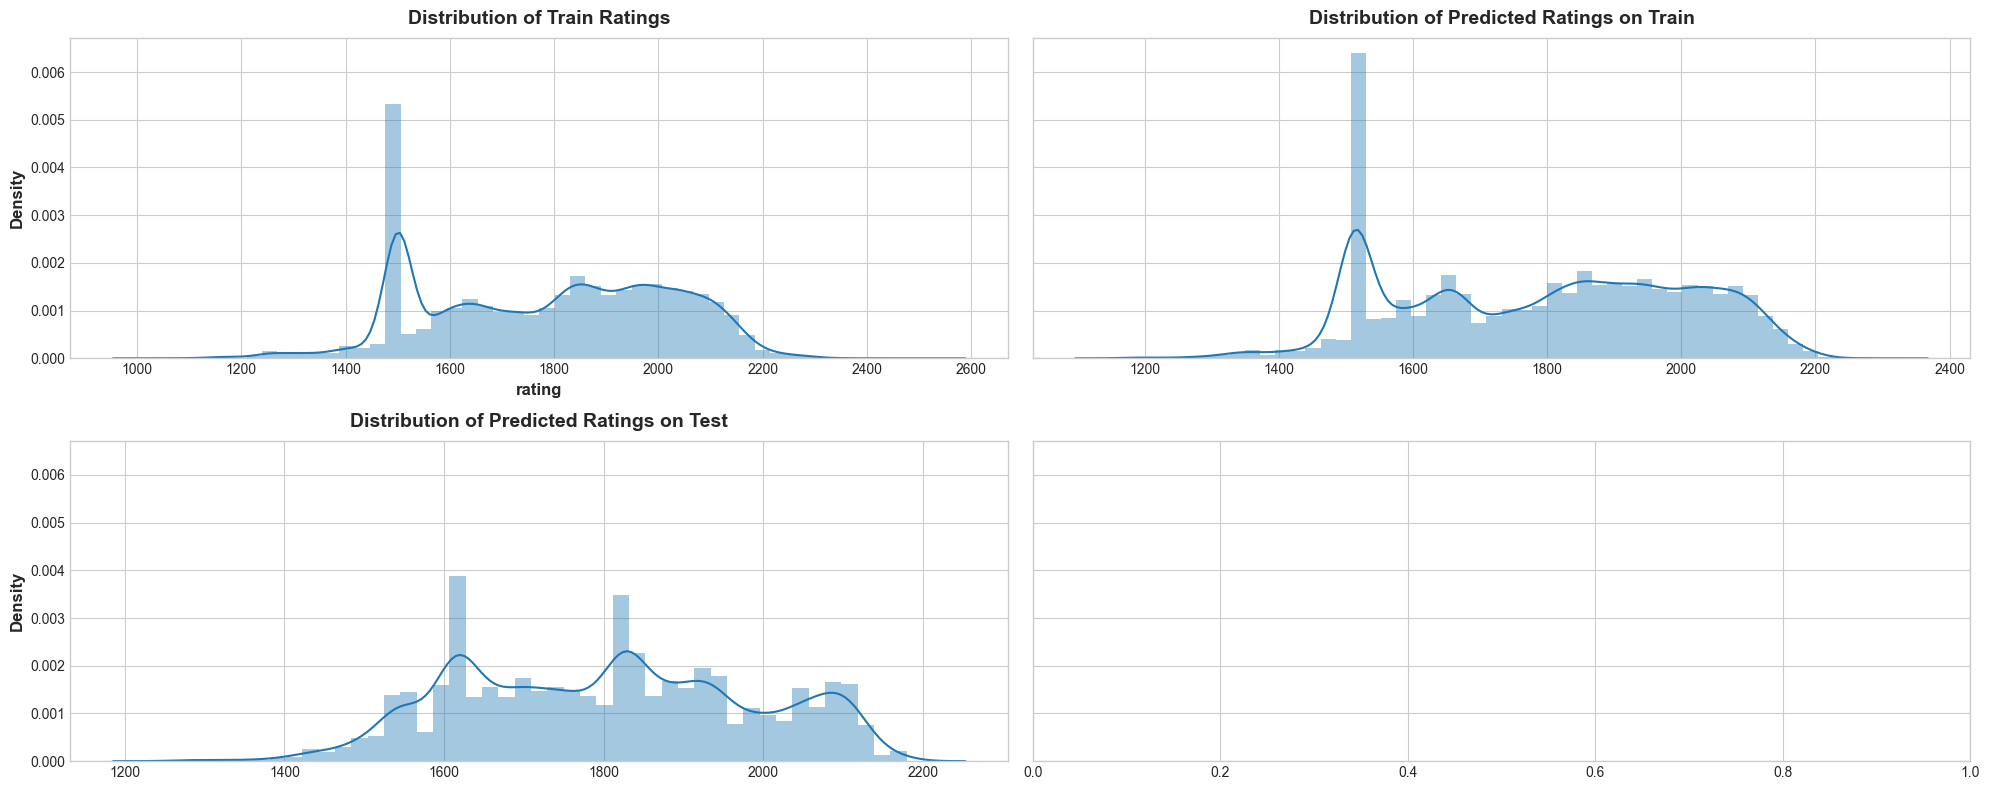

In [103]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(20,8))
sns.distplot(train['rating'], ax=axs[0,0])
axs[0,0].set_title("Distribution of Train Ratings")
sns.distplot(final_train_preds , ax=axs[0,1])
axs[0,1].set_title("Distribution of Predicted Ratings on Train")
sns.distplot(final_test_preds , ax=axs[1,0])
axs[1,0].set_title("Distribution of Predicted Ratings on Test")

In [104]:
test['rating'] = final_test_preds
submission = test['rating']
submission.to_csv("submission.csv")